## Import Necessary Libraries

In [3]:
import numpy as np
import pathlib
import pandas as pd
import nibabel as nib
from scipy import ndimage
import os
import os.path
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from utils_chest import get_dataframe, resample_dataset,evalutation_score,get_resampled_dataframe
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
data_folder='/user/gr1/delphi/tsaha/code/Data_128'

In [ ]:
# Run only once
# df = get_dataframe(data_folder=pathlib.Path(data_folder), seed=42)
# df = df.sort_index()
# df.to_excel('df.xlsx', index=False)

# Resample dataframe to have the same voxel size and the same number of slices
# target_voxel_sizes = [np.min(df['voxel_size_1']), np.min(df['voxel_size_2']), np.min(df['voxel_size_3'])]
# df_resampled = resample_dataset(df,target_voxel_sizes)

In [5]:
# Use this everytime when starting or when kernal crashes unexpetedly

df = pd.read_excel('df.xlsx', engine='openpyxl')
df_resampled = get_resampled_dataframe(data_folder=pathlib.Path(data_folder), seed=42)

In [6]:
print(df.head(2))
print(df_resampled.head(2))

  patient_id                                     ct_scan_path  risk  slices  \
0    AMC-001  /user/gr1/delphi/tsaha/code/Data/AMC-001.nii.gz     1     253   
1    AMC-002  /user/gr1/delphi/tsaha/code/Data/AMC-002.nii.gz     0     271   

   voxel_size_1  voxel_size_2  voxel_size_3  
0      0.742188      0.742188          1.25  
1      0.548828      0.548828          1.00  
  patient_id                                       ct_scan_path risk  slices  \
0    AMC-001  /user/gr1/delphi/tsaha/code/Data_128/AMC-001_r...    1   112.0   
1    AMC-002  /user/gr1/delphi/tsaha/code/Data_128/AMC-002_r...    0   112.0   

   voxel_size_1  voxel_size_2  voxel_size_3  
0      0.458984      0.458984         0.625  
1      0.458984      0.458984         0.625  


In [11]:
stacked_x = []
for scan in df_resampled['ct_scan_path']:
    patient_3D_scan = nib.load(scan).get_fdata() # Reads the nii files
    stacked_x.append(torch.tensor(patient_3D_scan))

stacked_x = np.array(torch.stack(stacked_x))
stacke_x=np.expand_dims(stacked_x, axis=4)

In [12]:
# Loading the labels for all patients CT scans. The CT scans which have "Recurrence" possibility has been marked as 
# 1 else 0
df = pd.read_csv('labels.csv')
labels = np.array([1 if d == 'yes' else 0 for d in df['Recurrence']])
x_train, x_test, y_train, y_test = train_test_split(stacke_x, labels, test_size=0.25, random_state=0)

## Data Preprocessing (To be done)

In [5]:
# Preprocessing steps on every CT scan slices
# example normalization, rotation etc

## Data Loaders

In [15]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 112, 1)


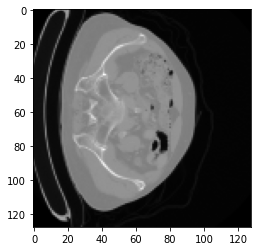

In [16]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

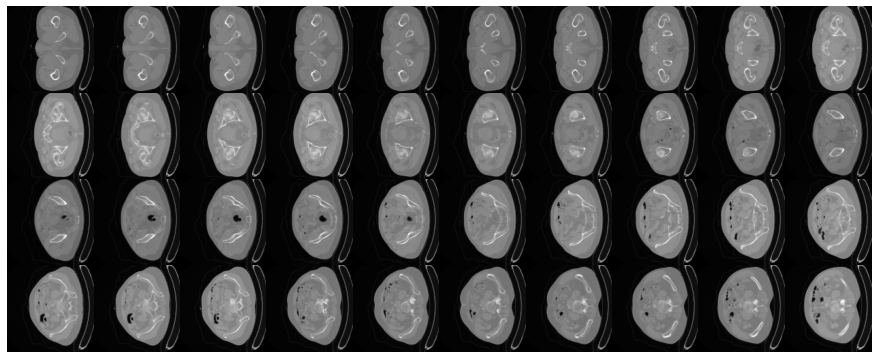

In [17]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## 3D Convolution Neural Network

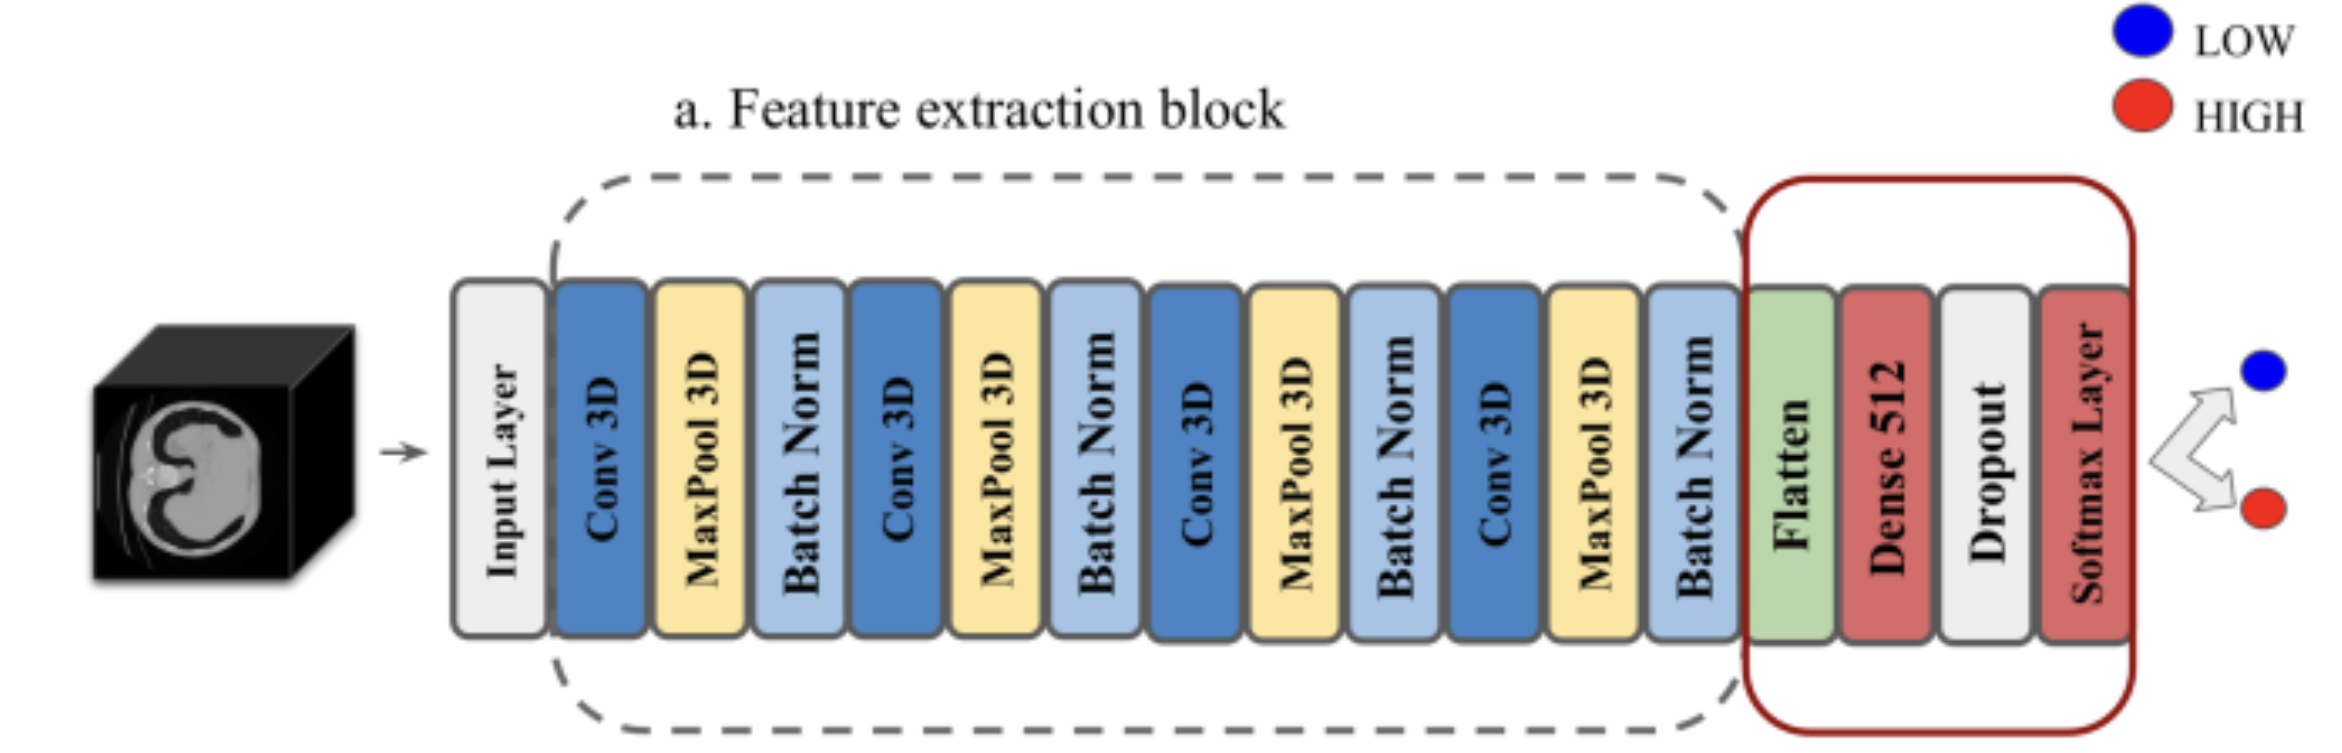


In [18]:
def my3DCNN(width=128, height=128, depth=112):
    """Build a 3D convolutional neural network model."""
    inputs = keras.Input((width, height, depth, 1))
    x = layers.Conv3D(filters=112, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=112, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model
    


# Build model.
model = my3DCNN(width=128, height=128, depth=112)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 112, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 110, 112 3136      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 55, 112)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 55, 112)   448       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 53, 112)   338800    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 26, 112)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 26, 112)   448   

## Training the Model

In [10]:
# Saving the data

np.save('x_train', x_train.astype(np.float32))
np.save('y_train', y_train.astype(np.int))
np.save('x_test', x_test.astype(np.float32))
np.save('y_test', y_test.astype(np.int))

In [ ]:
# Compile model.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my3DCNN.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
my_input = tf.constant(np.load('/user/gr1/delphi/tsaha/code/x_train.npy').astype(np.float32))
my_target = tf.expand_dims(tf.constant(np.load('/user/gr1/delphi/tsaha/code/y_train.npy').astype(np.float32)), axis=1)
my_test_input = tf.constant(np.load('/user/gr1/delphi/tsaha/code/x_test.npy').astype(np.float32))
my_test_target = tf.expand_dims(tf.constant(np.load('/user/gr1/delphi/tsaha/code/y_test.npy').astype(np.float32)), axis=1)

epochs = 6

model.fit(my_input, my_target,epochs=epochs,
    batch_size = 5,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],)

model.save("3dCNN_v1.0.h5")

print("Model Saved Successfully!!")

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# load the saved model (use the version carefully)
new_model = keras.models.load_model("3dCNN.h5")

# Get the predictions
predictions = new_model.predict(my_test_input)
loss, accuracy = new_model.evaluate(my_test_input, my_test_target)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 36s 14s/step - loss: 1.2421 - acc: 0.6792
Test Loss: 1.2420611381530762
Test Accuracy: 0.6792452931404114


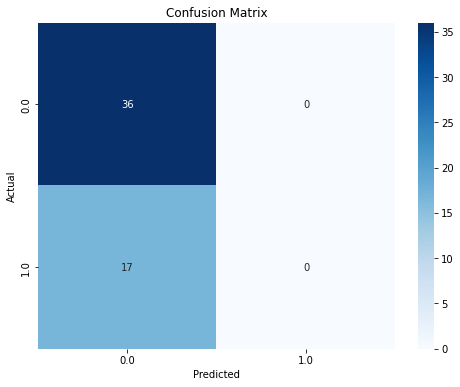

In [20]:
# Plot the confusion matrix

threshold = 0.5
y_true = np.array(my_test_target)
y_pred =  (predictions >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Reference Paper

Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction by Hasib Zunair, Aimon Rahman, Nabeel Mohammed, Joseph Paul Cohen.
https://arxiv.org/abs/2007.13224

The paper was published in the following book:

title={Uniformizing Techniques to Process CT Scans with 3D CNNs for Tuberculosis Prediction},

author={Zunair, Hasib and Rahman, Aimon and Mohammed, Nabeel and Cohen, Joseph Paul},

booktitle={International Workshop on PRedictive Intelligence In MEdicine},

pages={156--168},

year={2020},

organization={Springer} }